# Combined Transferability Analysis: e20 + e21

This notebook combines runs from both experiments:
- **e20** (`e20TG_neurogf_terrain_graphs`): Resolutions 1-20
- **e21** (`e21TG_smaller_fracions_deeper_k`): Resolutions 21-40

Creates transferability plots comparing SparseGT and TAGConv performance across all resolutions (1-40).


In [50]:
import wandb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Initialize wandb API
api = wandb.Api()


## Fetch Runs from Both Experiments


In [51]:
ENTITY = 'alelab'
PROJECT = 'terrains'

# Both experiment tags
TAG_E20 = 'e20TG_neurogf_terrain_graphs'
TAG_E21 = 'e21TG_smaller_fracions_deeper_k'


def fetch_runs_by_tag(entity: str, project: str, tag: str, experiment_name: str) -> pd.DataFrame:
    """
    Fetch runs from a wandb project filtered by tag.
    
    Args:
        entity: wandb entity (user or team)
        project: wandb project name
        tag: wandb tag to filter runs
        experiment_name: name to identify the experiment source
    
    Returns:
        DataFrame with run information
    """
    filters = {
        "$and": [
            {"$or": [{"state": "running"}, {"state": "finished"}]},
            {"tags": {"$in": [tag]}}
        ]
    }
    runs = api.runs(f"{entity}/{project}", filters=filters)
    
    records = []
    for run in runs:
        summary = run.summary._json_dict
        config = run.config
        
        # Get normalized_abs_error
        normalized_abs_error = summary.get('normalized_abs_error') or summary.get('normalized_abs_err', 0)
        
        if not normalized_abs_error or normalized_abs_error == 0:
            continue
        
        # Extract resolution from dataset_name or train_data
        dataset_name = config.get('dataset_name', '')
        train_data = config.get('train_data', '')
        
        res_match = re.search(r'res(\d+)', dataset_name) or re.search(r'res(\d+)', train_data)
        if res_match:
            resolution = int(res_match.group(1))
        else:
            continue
        
        records.append({
            'run_id': run.id,
            'run_name': run.name,
            'state': run.state,
            'resolution': resolution,
            'normalized_abs_error': normalized_abs_error,
            'layer_type': config.get('layer_type', 'Unknown'),
            'epochs': config.get('epochs', 0),
            'learning_rate': config.get('learning_rate', 0),
            'dataset_name': dataset_name,
            'experiment': experiment_name,
        })
    
    return pd.DataFrame(records)


# Fetch runs from both experiments
print(f"Fetching runs from {ENTITY}/{PROJECT}...")
print(f"  Tag: {TAG_E20}")
df_e20 = fetch_runs_by_tag(ENTITY, PROJECT, TAG_E20, 'e20')
print(f"  Found {len(df_e20)} runs from e20")

print(f"  Tag: {TAG_E21}")
df_e21 = fetch_runs_by_tag(ENTITY, PROJECT, TAG_E21, 'e21')
print(f"  Found {len(df_e21)} runs from e21")

# Combine and deduplicate
df = pd.concat([df_e20, df_e21], ignore_index=True).drop_duplicates(subset='run_id')
print(f"\nTotal combined runs: {len(df)}")


Fetching runs from alelab/terrains...
  Tag: e20TG_neurogf_terrain_graphs
  Found 63 runs from e20
  Tag: e21TG_smaller_fracions_deeper_k
  Found 80 runs from e21

Total combined runs: 143


In [52]:
# Normalize layer_type to consistent model names
model_type_map = {
    'TAGConv': 'TAGConv',
    'SparseGT': 'SparseGT',
    'MLP': 'MLP',
}
df['model_type'] = df['layer_type'].map(model_type_map).fillna(df['layer_type'])

print(f"Model types found:")
print(df['model_type'].value_counts())
print(f"\nResolutions available: {sorted(df['resolution'].unique())}")


Model types found:
model_type
TAGConv     76
SparseGT    67
Name: count, dtype: int64

Resolutions available: [np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40)]


In [53]:
df

,run_id,run_name,state,resolution,normalized_abs_error,layer_type,epochs,learning_rate,dataset_name,experiment,model_type
0,cehkvmr9,terrain-graph-TAGConv-stage1,finished,20,0.018958,TAGConv,500,0.0001,norway/res20,e20,TAGConv
1,fjmvtepv,terrain-graph-TAGConv-stage1,finished,19,0.017410,TAGConv,500,0.0001,norway/res19,e20,TAGConv
2,j7q1o47n,terrain-graph-TAGConv-stage2,finished,20,0.004849,TAGConv,1000,0.0010,res20_phase2,e20,TAGConv
3,rxju6dat,terrain-graph-TAGConv-stage2,finished,19,0.004669,TAGConv,1000,0.0010,res19_phase2,e20,TAGConv
4,c64bcxcq,terrain-graph-TAGConv-stage1,finished,18,0.022063,TAGConv,500,0.0001,norway/res18,e20,TAGConv
...,...,...,...,...,...,...,...,...,...,...,...
138,iz9ym5be,terrain-graph-SparseGT-res40-stage1,finished,40,0.021278,SparseGT,250,0.0001,norway/res40,e21,SparseGT
139,b3gyw1rq,terrain-graph-SparseGT-res38_phase2-stage2,finished,38,0.004224,SparseGT,250,0.0010,res38_phase2,e21,SparseGT
140,29gtde2q,terrain-graph-SparseGT-res37_phase2-stage2,finished,37,0.005658,SparseGT,250,0.0010,res37_phase2,e21,SparseGT
141,kykkwg4b,terrain-graph-SparseGT-res39_phase2-stage2,finished,39,0.007946,SparseGT,250,0.0010,res39_phase2,e21,SparseGT


In [54]:
# Compute number of nodes per resolution
# The Norway DEM has original shape (2000, 2000)
# Resolution is used as a stride: [::res, ::res]
# Number of nodes = ((original_dim - 1) // res + 1)^2

ORIGINAL_DIM = 2000  # Norway terrain grid dimension

def compute_num_nodes(resolution, original_dim=ORIGINAL_DIM):
    """Compute number of nodes for a given resolution (stride) and original grid dimension."""
    grid_size = (original_dim - 1) // resolution + 1
    return grid_size * grid_size

# Create a reference table
node_counts = pd.DataFrame({
    'resolution': range(1, 41),
    'num_nodes': [compute_num_nodes(r) for r in range(1, 41)]
})
node_counts['grid_size'] = node_counts['resolution'].apply(lambda r: (ORIGINAL_DIM - 1) // r + 1)

print("Number of nodes per resolution (Norway 2000x2000 terrain):")
print(node_counts.to_string(index=False))


Number of nodes per resolution (Norway 2000x2000 terrain):
 resolution  num_nodes  grid_size
          1    4000000       2000
          2    1000000       1000
          3     444889        667
          4     250000        500
          5     160000        400
          6     111556        334
          7      81796        286
          8      62500        250
          9      49729        223
         10      40000        200
         11      33124        182
         12      27889        167
         13      23716        154
         14      20449        143
         15      17956        134
         16      15625        125
         17      13924        118
         18      12544        112
         19      11236        106
         20      10000        100
         21       9216         96
         22       8281         91
         23       7569         87
         24       7056         84
         25       6400         80
         26       5929         77
         27       5625 

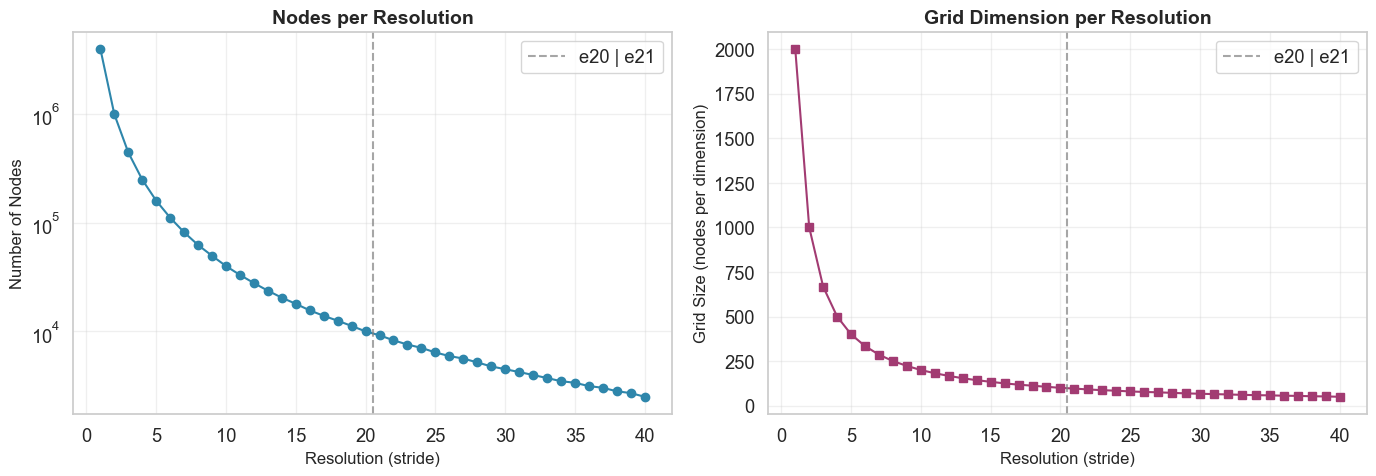


Key resolutions:
  res= 1: 2000x2000 =  4,000,000 nodes
  res= 5:  400x400  =    160,000 nodes
  res=10:  200x200  =     40,000 nodes
  res=15:  134x134  =     17,956 nodes
  res=20:  100x100  =     10,000 nodes
  res=25:   80x80   =      6,400 nodes
  res=30:   67x67   =      4,489 nodes
  res=35:   58x58   =      3,364 nodes
  res=40:   50x50   =      2,500 nodes


In [55]:
# Visualize node counts vs resolution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Node count vs resolution (log scale)
ax1 = axes[0]
ax1.plot(node_counts['resolution'], node_counts['num_nodes'], 'o-', color='#2E86AB', markersize=6)
ax1.set_xlabel('Resolution (stride)', fontsize=12)
ax1.set_ylabel('Number of Nodes', fontsize=12)
ax1.set_title('Nodes per Resolution', fontsize=14, fontweight='bold')
ax1.set_yscale('log')
ax1.axvline(x=20.5, color='gray', linestyle='--', alpha=0.7, label='e20 | e21')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Right: Grid size vs resolution
ax2 = axes[1]
ax2.plot(node_counts['resolution'], node_counts['grid_size'], 's-', color='#A23B72', markersize=6)
ax2.set_xlabel('Resolution (stride)', fontsize=12)
ax2.set_ylabel('Grid Size (nodes per dimension)', fontsize=12)
ax2.set_title('Grid Dimension per Resolution', fontsize=14, fontweight='bold')
ax2.axvline(x=20.5, color='gray', linestyle='--', alpha=0.7, label='e20 | e21')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Print key node counts
print("\nKey resolutions:")
for res in [1, 5, 10, 15, 20, 25, 30, 35, 40]:
    nc = compute_num_nodes(res)
    gs = (ORIGINAL_DIM - 1) // res + 1
    print(f"  res={res:2d}: {gs:4d}x{gs:<4d} = {nc:>10,} nodes")


In [56]:
# Extract stage from dataset_name
def extract_stage(row):
    dataset_name = row['dataset_name']
    
    # norway/res## = stage 1 (Phase 1 GNN training)
    if 'norway/' in dataset_name:
        return 1
    # res##_phase{num} = stage num (Phase 2 MLP finetuning)
    match = re.search(r'_phase(\d+)', dataset_name)
    if match:
        return int(match.group(1))
    return None

df['stage'] = df.apply(extract_stage, axis=1)

print("Stage distribution by model type and experiment:")
print(df.groupby(['experiment', 'model_type', 'stage']).size().unstack(fill_value=0))


Stage distribution by model type and experiment:
stage                   1   2
experiment model_type        
e20        SparseGT    14  13
           TAGConv     17  19
e21        SparseGT    20  20
           TAGConv     20  20


In [57]:
# Filter to main model types (exclude MLP-only runs)
df_main = df[df['model_type'].isin(['TAGConv', 'SparseGT'])].copy()
print(f"Filtered to main models: {len(df_main)} runs")
print(f"\nRuns per model type:")
print(df_main['model_type'].value_counts())


Filtered to main models: 143 runs

Runs per model type:
model_type
TAGConv     76
SparseGT    67
Name: count, dtype: int64


In [58]:
# Number of nodes per resolution
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   run_id                143 non-null    object 
 1   run_name              143 non-null    object 
 2   state                 143 non-null    object 
 3   resolution            143 non-null    int64  
 4   normalized_abs_error  143 non-null    float64
 5   layer_type            143 non-null    object 
 6   epochs                143 non-null    int64  
 7   learning_rate         143 non-null    float64
 8   dataset_name          143 non-null    object 
 9   experiment            143 non-null    object 
 10  model_type            143 non-null    object 
 11  stage                 143 non-null    int64  
dtypes: float64(2), int64(3), object(7)
memory usage: 13.5+ KB


## Transferability Plots by Resolution


In [59]:
# Set plot style
sns.set_theme(style="whitegrid", font_scale=1.2)

# Separate by stage
df_stage1 = df_main[df_main['stage'] == 1].copy()
df_stage2 = df_main[df_main['stage'] == 2].copy()

print(f"Stage 1 runs: {len(df_stage1)}")
print(f"Stage 2 runs: {len(df_stage2)}")
print(f"Resolution range: {df_main['resolution'].min()} to {df_main['resolution'].max()}")

# Define colors and markers
colors = {'TAGConv': '#457B9D', 'SparseGT': '#E63946'}
markers = {'TAGConv': 'o', 'SparseGT': 's'}


Stage 1 runs: 71
Stage 2 runs: 72
Resolution range: 2 to 40


In [60]:
# Best performance per resolution per model for Stage 1
df_best_stage1 = df_stage1.loc[df_stage1.groupby(['model_type', 'resolution'])['normalized_abs_error'].idxmin()]

# Best performance per resolution per model for Stage 2
df_best_stage2 = df_stage2.loc[df_stage2.groupby(['model_type', 'resolution'])['normalized_abs_error'].idxmin()]

print(f"Best runs per resolution - Stage 1: {len(df_best_stage1)}, Stage 2: {len(df_best_stage2)}")


Best runs per resolution - Stage 1: 69, Stage 2: 71


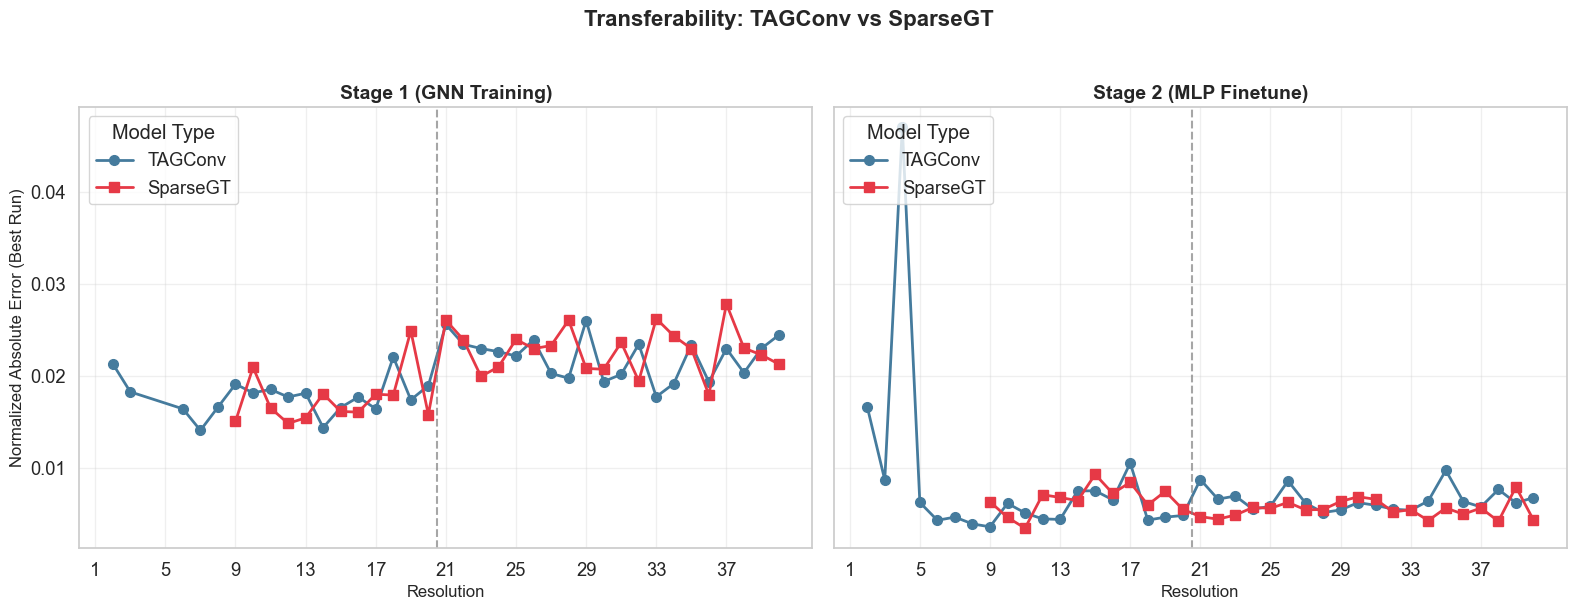

In [61]:
# VIEW 1: TAGConv vs SparseGT - Faceted by Stage
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

stage_data_map = {1: df_best_stage1, 2: df_best_stage2}
stage_titles = {1: 'Stage 1 (GNN Training)', 2: 'Stage 2 (MLP Finetune)'}

for idx, stage in enumerate([1, 2]):
    ax = axes[idx]
    df_best = stage_data_map[stage]
    
    for model_type in ['TAGConv', 'SparseGT']:
        data = df_best[df_best['model_type'] == model_type].sort_values('resolution')
        ax.plot(
            data['resolution'], 
            data['normalized_abs_error'],
            marker=markers[model_type],
            color=colors[model_type],
            linewidth=2,
            markersize=7,
            label=model_type
        )
    
    ax.axvline(x=20.5, color='gray', linestyle='--', alpha=0.7)
    ax.set_xlabel('Resolution', fontsize=12)
    if idx == 0:
        ax.set_ylabel('Normalized Absolute Error (Best Run)', fontsize=12)
    ax.set_title(stage_titles[stage], fontsize=14, fontweight='bold')
    ax.legend(title='Model Type', loc='upper left')
    ax.set_xticks(range(1, 41, 4))
    ax.grid(True, alpha=0.3)

fig.suptitle('Transferability: TAGConv vs SparseGT', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('e20_e21_by_stage.png', dpi=150, bbox_inches='tight')
plt.show()


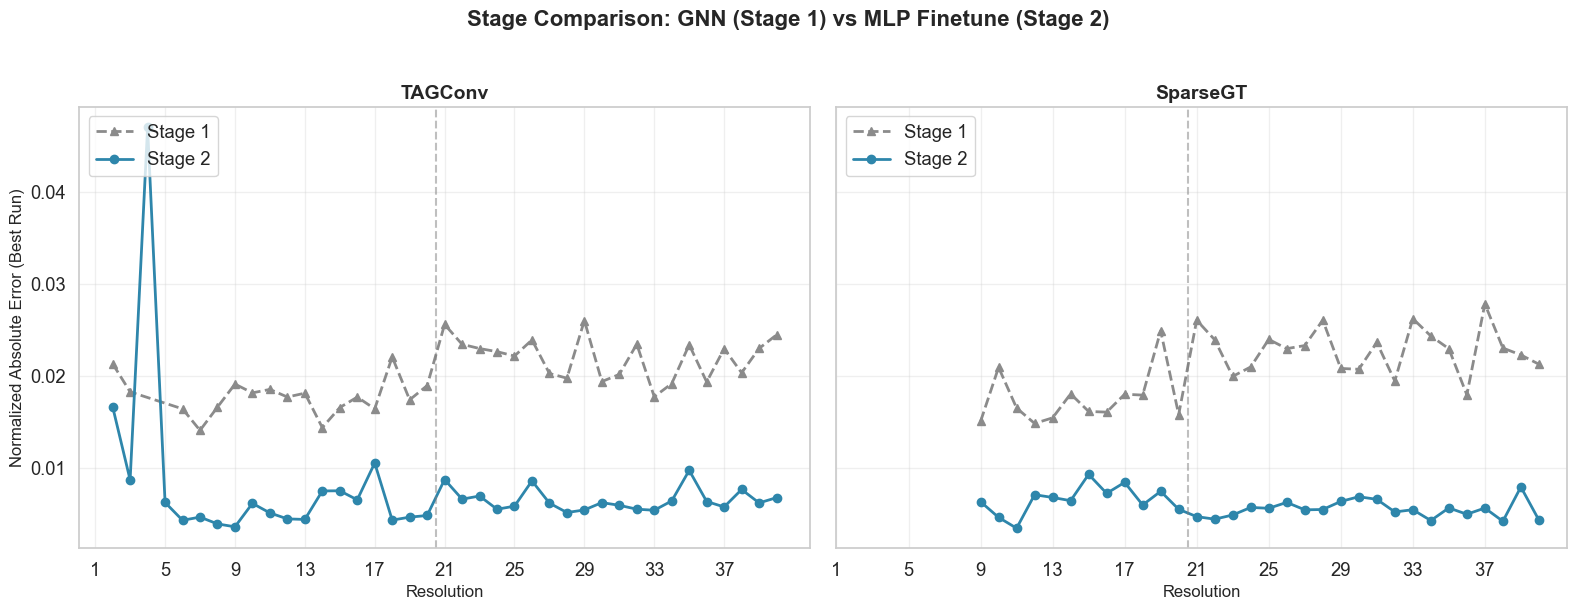

In [65]:
# VIEW 2: Stage 1 vs Stage 2 - Faceted by Model
# Combine best runs from both stages
df_best_stage1['stage'] = 1
df_best_stage2['stage'] = 2
df_best_combined = pd.concat([df_best_stage1, df_best_stage2], ignore_index=True)

stage_colors = {1: '#8B8B8B', 2: '#2E86AB'}  # Gray for Stage 1, Blue for Stage 2
stage_markers = {1: '^', 2: 'o'}
stage_linestyles = {1: '--', 2: '-'}

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

for idx, model_type in enumerate(['TAGConv', 'SparseGT']):
    ax = axes[idx]
    data = df_best_combined[df_best_combined['model_type'] == model_type]
    
    for stage in [1, 2]:
        stage_data = data[data['stage'] == stage].sort_values('resolution')
        ax.plot(
            stage_data['resolution'],
            stage_data['normalized_abs_error'],
            marker=stage_markers[stage],
            color=stage_colors[stage],
            linestyle=stage_linestyles[stage],
            linewidth=2,
            markersize=6,
            label=f'Stage {stage}'
        )
    
    ax.axvline(x=20.5, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Resolution', fontsize=12)
    if idx == 0:
        ax.set_ylabel('Normalized Absolute Error (Best Run)', fontsize=12)
    ax.set_title(f'{model_type}', fontsize=14, fontweight='bold')
    ax.legend(loc='upper left')
    ax.set_xticks(range(1, 41, 4))
    ax.grid(True, alpha=0.3)

fig.suptitle('Stage Comparison: GNN (Stage 1) vs MLP Finetune (Stage 2)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('e20_e21_by_model.png', dpi=150, bbox_inches='tight')
plt.show()


In [63]:
## Summary Statistics


# Find best resolution per model and stage
print("Best Resolution per Model Type:\n")
for stage, df_best in [(1, df_best_stage1), (2, df_best_stage2)]:
    best = df_best.loc[df_best.groupby('model_type')['normalized_abs_error'].idxmin()]
    print(f"Stage {stage}:")
    print(best[['model_type', 'resolution', 'normalized_abs_error']].to_string(index=False))
    print()


In [67]:
# Performance summary by resolution range
df_best_stage2['res_range'] = df_best_stage2['resolution'].apply(lambda x: 'e20 (1-20)' if x <= 20 else 'e21 (21-40)')
range_summary = df_best_stage2.groupby(['model_type', 'res_range'])['normalized_abs_error'].agg(['mean', 'min', 'max', 'count']).round(6)
print("Stage 2 Performance by Resolution Range:")
range_summary


Stage 2 Performance by Resolution Range:


mean       min       max  count
model_type res_range                                       
SparseGT   e20 (1-20)   0.006569  0.003469  0.009316     12
           e21 (21-40)  0.005520  0.004224  0.007946     20
TAGConv    e20 (1-20)   0.008495  0.003620  0.047005     19
           e21 (21-40)  0.006566  0.005170  0.009752     20